In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import minmax_scale,maxabs_scale
from anndata import AnnData

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
from matplotlib.patches import Patch
import altair as alt

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R object with classes: ('list',) mapped to:
[SexpClosure, BoolSexpVector]
  value: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x7f6bc2ac1c40> [RTYPES.CLOSXP]
  visible: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x7f6bc2ac1480> [RTYPES.LGLSXP]

In [3]:
%%R
library('ComplexHeatmap')
library(viridis)
library(proxy)
library(seriation)
library(dendextend)

In [4]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'
compass_dir='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/compass/data_integrated_analysed_beta_v1s1_sfintegrated/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/de_diseased_T2_VSGSTZ_meld_covarStudy/'

In [5]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [5]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

In [13]:
beta_obs=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
                 backed='r').obs.copy()

In [6]:
# Load all cell data for embryo analysis
adata_rn=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad')
# Use correctly normalised counts
adata_rn.X=adata_rn.layers['X_sf_integrated']

In [9]:
# Load DE data
result=pickle.load(
    open(path_de+'healthyDiseased_minCellsRatio0.05.pkl','rb'))
summary=result.summary()
summary.index=summary.gene

In [168]:
# Add gene symbols
summary['gene_symbol']=h.get_symbols(summary.index)

In [169]:
# Check that gene symbols not nan -
if (summary.gene_symbol=='nan').sum() :
        raise ValueError('Some gene symbols are nan - requires different parsing')

## Gene clustering

### Prepare data for gene clustering

Pseudobulk

In [37]:
# Make pseudobulk adata 
data=adata_rn_b.to_df()
data['group']=adata_rn_b.obs['leiden_r20']
data=data.groupby('group').mean()
adata_pb=AnnData(data)
adata_pb.shape

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(411, 30672)

Adata of all de genes for clustering

In [13]:
FDR=0.05
ALFC=1

In [11]:
# Make adata_genes so that code from other nbs can be reused
adata_genes=adata_pb[:,summary.query('qval<@FDR & abs(log2fc)>@ALFC').index].copy().T

Remove possible ambient genes

In [5]:
# load genes info for expression, rel beta expression, and citation info
genes_info=pd.read_table(path_genes+'genePrioritisation_beta.tsv',index_col=0)

In [51]:
# Add relative beta expression strength to genes adata
adata_genes.obs['rel_maxscl_beta_expr_cl']=genes_info.loc[adata_genes.obs_names,'rel_maxscl_beta_expr_cl']

In [76]:
# Keep only genes that do not have relatively low expression in beta cells
adata_genes=adata_genes[adata_genes.obs['rel_maxscl_beta_expr_cl']>0.2,:].copy()
adata_genes.shape[0]

1253

### Compute clusters for up and down

In [57]:
# Cutting threshold
cut_thresh=3
# Remove previous clusters
if 'hc' in adata_genes.obs.columns:
    adata_genes.obs.drop('hc',axis=1,inplace=True)

Up

In [58]:
# Compute hc
genes_up=[g for g in adata_genes.obs_names if summary.at[g,'log2fc']>0]
dist=pdist(adata_genes[genes_up,:].X,metric='correlation')
hc=linkage(dist, method='ward',  optimal_ordering=True)

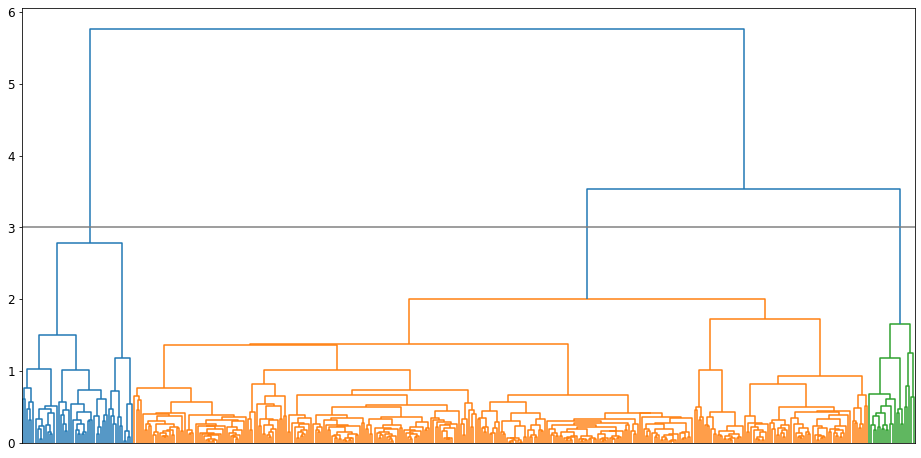

In [59]:
# Plot dendrogram
rcParams['figure.figsize']=(16,8)
adata_genes.uns['hc_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
hierarchy.set_link_color_palette(adata_genes.uns['hc_colors'])
dend=dendrogram(hc,color_threshold=cut_thresh,no_labels=True)
plt.axhline(cut_thresh,c='gray')

In [60]:
# Extract clusters at selected cutting threshold
adata_genes.obs.loc[genes_up,'hc']=['up_'+str(cl)
                                      for cl in fcluster(hc,t=cut_thresh,criterion='distance')]

Down

In [61]:
# Compute hc
genes_down=[g for g in adata_genes.obs_names if summary.at[g,'log2fc']<0]
dist=pdist(adata_genes[genes_down,:].X,metric='correlation')
hc=linkage(dist, method='ward',  optimal_ordering=True)

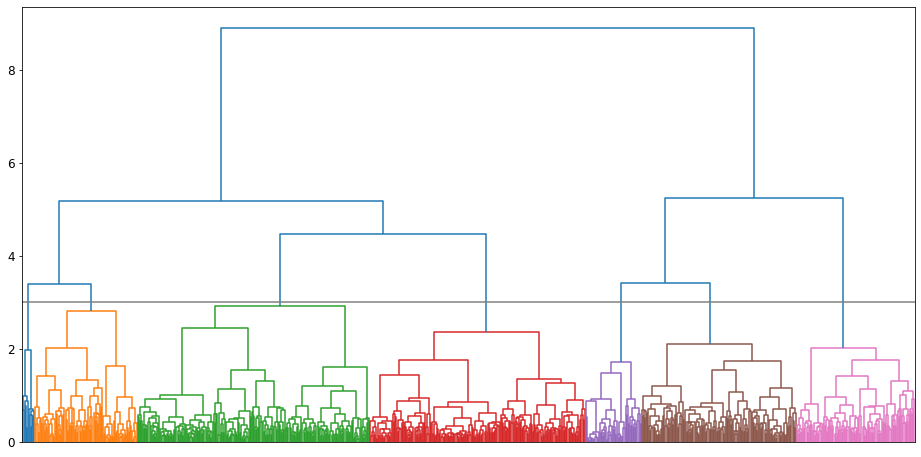

In [62]:
# Plot dendrogram
rcParams['figure.figsize']=(16,8)
adata_genes.uns['hc_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
hierarchy.set_link_color_palette(adata_genes.uns['hc_colors'])
dend=dendrogram(hc,color_threshold=cut_thresh,no_labels=True)
plt.axhline(cut_thresh,c='gray')

In [63]:
# Extract clusters at selected cutting threshold
adata_genes.obs.loc[genes_down,'hc']=['down_'+str(cl )
                                      for cl in fcluster(hc,t=cut_thresh,criterion='distance')]

## Analyse clusters

### N clusters and their sizes

In [64]:
adata_genes.obs.hc=adata_genes.obs.hc.astype('category')
print('N gene clusters:',adata_genes.obs.hc.nunique())

N gene clusters: 10


In [70]:
# Cluster sizes
adata_genes.obs['hc'].value_counts()

up_2      349
down_3    216
down_4    200
down_6    144
down_7    110
down_2     95
up_1       53
down_5     52
up_3       22
down_1     12
Name: cl, dtype: int64

Visualise cl sizes and direction

In [71]:
# Add DE direction to adata_genes
adata_genes.obs['de_direction']=(summary.loc[adata_genes.obs_names,'log2fc']>0
                            ).map({False:'healthy',True:'diseased'})

In [72]:
# N up/down genes in each group
alt.Chart(adata_genes.obs).mark_bar().encode(
    x=alt.X('count(de_direction)'
            #, stack="normalize"
           ),
    y='hc',
    color='de_direction'
)

alt.Chart(...)

### Cluster expression

Expression of DE gene clusters across cells

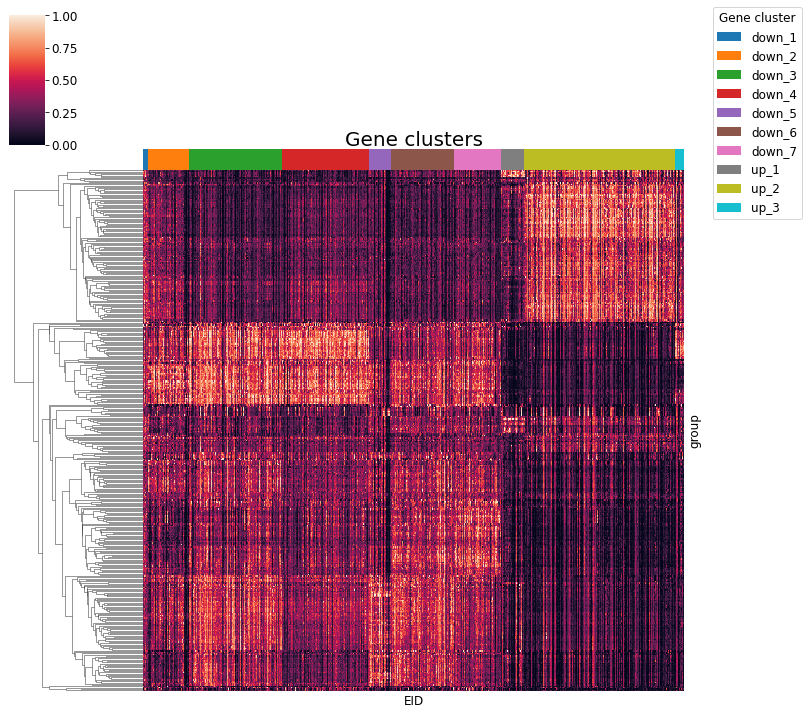

In [65]:
# Prepare data for gene clusters heatmap
# Which clustering to show
gene_clustering='hc'
# ordered genes by clusters
gene_list=[gene for cl in adata_genes.obs[gene_clustering].cat.categories
           for gene in adata_genes.obs_names[adata_genes.obs[gene_clustering]==cl]]
# ordered gene colors 
cl_list=[adata_genes.uns[gene_clustering+'_colors'][idx] for idx,cl in 
         enumerate(adata_genes.obs[gene_clustering].cat.categories)
         for gene in adata_genes.obs_names[adata_genes.obs[gene_clustering]==cl]]

x_temp=pd.DataFrame(minmax_scale(adata_genes.X.T),
                    index=adata_genes.var_names,columns=adata_genes.obs_names)[gene_list]
fg=sb.clustermap(x_temp, 
              col_colors=cl_list, 
              col_cluster=False,row_cluster=True,
             xticklabels=False, yticklabels=False)
 # Adds block annotation titles as axis labels
fg.ax_col_colors.set_xlabel('Gene clusters',fontsize=20)
fg.ax_col_colors.xaxis.set_label_position('top') 
# legend for gene clusters
handles = [Patch(facecolor=c) for c in adata_genes.uns[gene_clustering+'_colors']]
plt.legend(handles, adata_genes.obs[gene_clustering].cat.categories, title='Gene cluster',
           bbox_to_anchor=(1.13, 1), bbox_transform=plt.gcf().transFigure)

Heatmap ordered within clusters

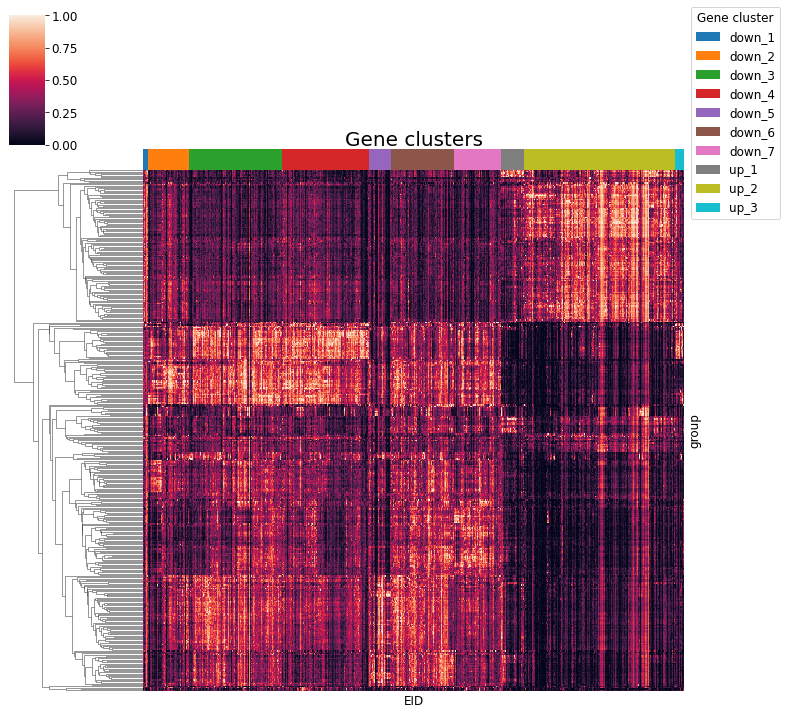

In [66]:
# Prepare some data for gene clusters heatmap
# Which clustering to show
gene_clustering='hc'
ad=adata_genes
# ordered genes by clusters
gene_list=[gene for cl in ad.obs[gene_clustering].cat.categories
           for gene in ad.obs_names[ad.obs[gene_clustering]==cl]]

# ordered gene colors 
cl_list=[ad.uns[gene_clustering+'_colors'][idx] for idx,cl in 
         enumerate(ad.obs[gene_clustering].cat.categories)
         for gene in ad.obs_names[ad.obs[gene_clustering]==cl]]

x_temp=pd.DataFrame( minmax_scale(ad.X.T),
                    index=ad.var_names,columns=ad.obs_names)[gene_list]

# Order within clusters
gene_list= h.opt_order_withincl(x_temp.T,ad.obs[gene_clustering])

fg=sb.clustermap(x_temp.loc[:,gene_list], 
              col_colors=cl_list, 
              col_cluster=False,row_cluster=True,
             xticklabels=False, yticklabels=False)
 # Adds block annotation titles as axis labels
fg.ax_col_colors.set_xlabel('Gene clusters',fontsize=20)
fg.ax_col_colors.xaxis.set_label_position('top') 
# legend for gene clusters
handles = [Patch(facecolor=c) for c in ad.uns[gene_clustering+'_colors']]
plt.legend(handles, adata_genes.obs[gene_clustering].cat.categories, title='Gene cluster',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure)
del ad
del x_temp

Distn of gene clusters scores on UMAP

In [73]:
# gene cluster scores
gene_cl='hc'
adata_rn_b.obs.drop([col for col in adata_rn_b.obs.columns 
                     if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
for ct in sorted(adata_genes.obs[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_rn_b, 
                      gene_list=adata_genes.obs_names[adata_genes.obs[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    adata_rn_b.obs[score_name+'_scaled']=minmax_scale(adata_rn_b.obs[score_name])

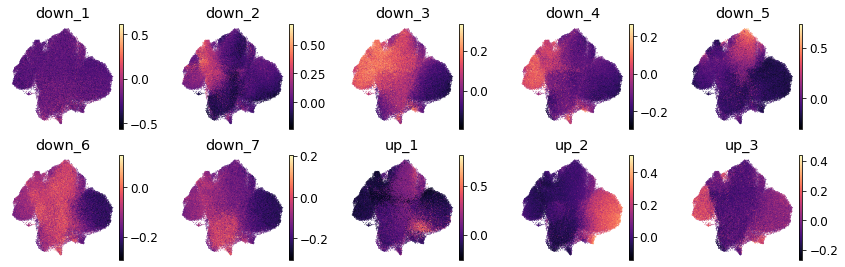

In [74]:
# plot gene clusters scores 
rcParams['figure.figsize']=(2,2)
cols=[col for col in adata_rn_b.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled' not in col]
random_indices=np.random.permutation(list(range(adata_rn_b.shape[0])))
g=sc.pl.umap(adata_rn_b[random_indices,:],color=cols, s=2,sort_order=False,ncols=5,
           color_map='magma',frameon=False,show=False,
           title=[c.replace('gene_score_cluster_hc','') for c in cols])
plt.savefig(path_fig+'umap_beta_DEVSGSTZ_clusters.png',dpi=300,bbox_inches='tight')

Distn of scores across samples

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'study_parsed_design_sample' as categorical


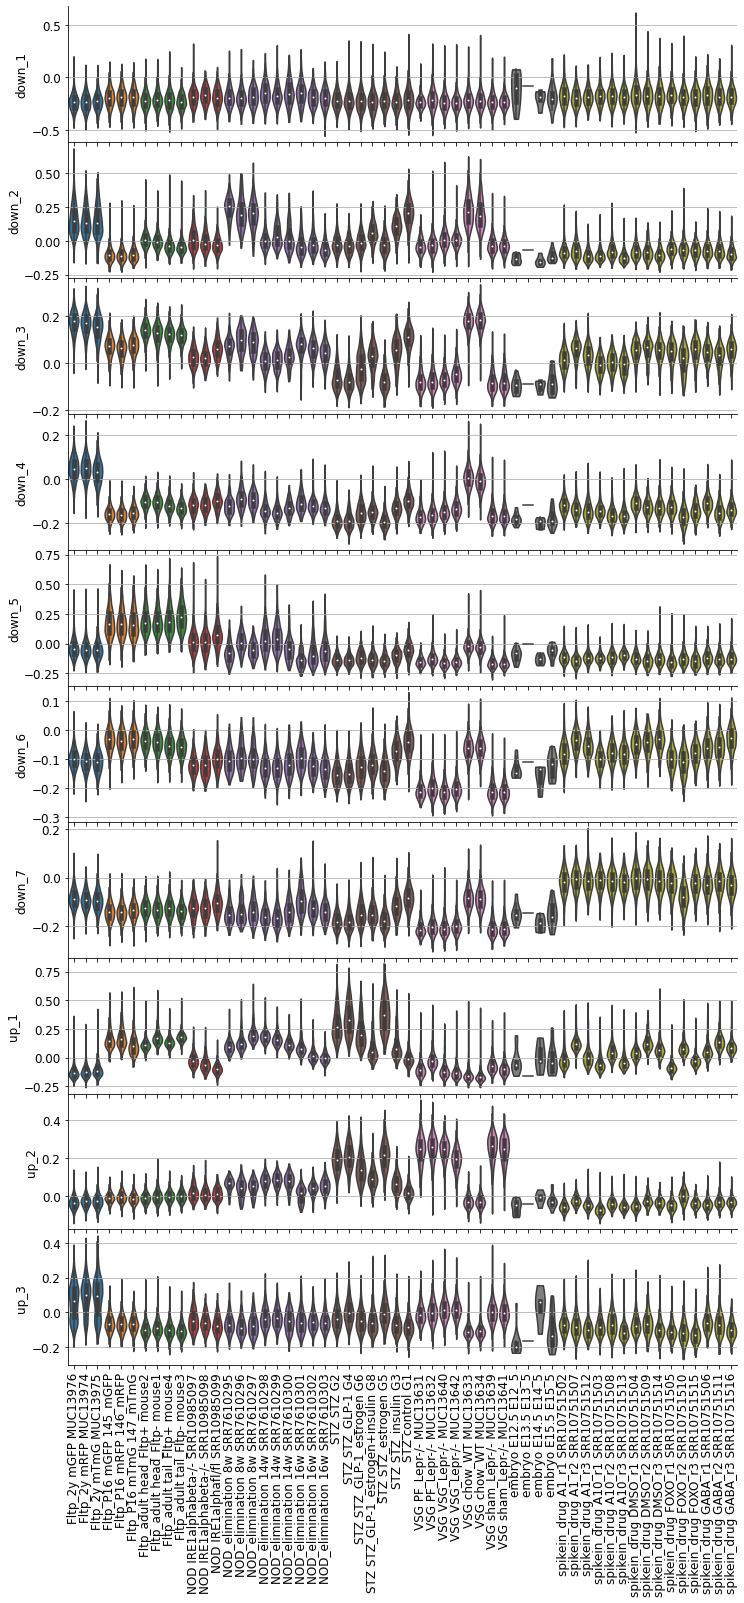

In [77]:
# Scores across samples, colored by study
adata_rn_b.obs['study_parsed_design_sample']=[
    ' '.join(i) for i in zip(
        adata_rn_b.obs['study'],adata_rn_b.obs['design'],adata_rn_b.obs['file'])]
# Color by study
palette=sc.plotting._tools.scatterplots._get_palette(adata_rn_b, 'study_parsed')
palette={sample:palette[adata_rn_b.obs.query(
    'study_parsed_design_sample==@sample').study_parsed[0]] 
       for sample in  adata_rn_b.obs['study_parsed_design_sample'].unique()}
cols=[col for col in adata_rn_b.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled' not in col]
# Joined plot for all clusters
fig,axs=plt.subplots(len(cols),1,sharex=True,figsize=(12,2.5*len(cols)))
for idx,score in enumerate(cols):
    ax=axs[idx]
    ax.grid(b=True,axis='y')
    sc.pl.violin(adata_rn_b, keys=score, 
                 groupby='study_parsed_design_sample', palette=palette,
                 stripplot=False,rotation=90,ax=ax,
                 show=False,inner='box',frameon=False)
    # Transparent
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(score.replace('gene_score_cluster_hc',''))
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(path_fig+'violin_beta_DEVSGSTZGroups_sample.png',dpi=300,bbox_inches='tight')

### Bio characterisation

#### Potential ambient
Relative beta expression for each cluster (how likely it is ambient - do genes look predominately ambient). It is possible that the potnetial ambient filtering did not remove all ambient genes.

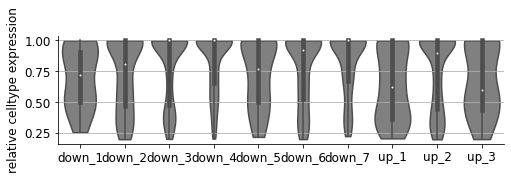

In [79]:
# Distn of relative beta expression strength across clusters
fig,ax=plt.subplots(figsize=(8,2))
ax.grid(b=True,axis='y')
sc.pl.violin(adata_genes, keys='rel_maxscl_beta_expr_cl', groupby='hc', 
             ax=ax,stripplot=False,inner='box',show=False,
             palette={g:'gray' for g in adata_genes.obs['hc'].unique()})
ax.set_ylabel('relative celltype expression')
ax.set_xlabel('')
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(path_fig+'violin_beta_DEVSGSTZGroups_relativectexpr.png',dpi=300,bbox_inches='tight')

#### Gene set enrichment
Gene set enrichment of the different DE gene groups

In [236]:
# Ref genes
ref=summary.gene_symbol.tolist()
ro.globalenv['ref']=ref

# Get gene sets
print('MSIGdb version:',ro.r(f'msigdb_version()'))
gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_kegg=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('KEGG'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_reactome=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('REACTOME'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
%R -i gene_sets_go -i gene_sets_kegg -i gene_sets_reactome -o gene_sets gene_sets=c(gene_sets_go,gene_sets_kegg,gene_sets_reactome)
print('N gene sets:',len(gene_sets))
ro.globalenv['gene_sets']=gene_sets

MSIGdb version: ['v7.4.1']
N gene sets: 9218


CL down_1 N genes 12
N enriched gene sets: 0
CL down_2 N genes 95
N enriched gene sets: 120
Top enriched gene sets


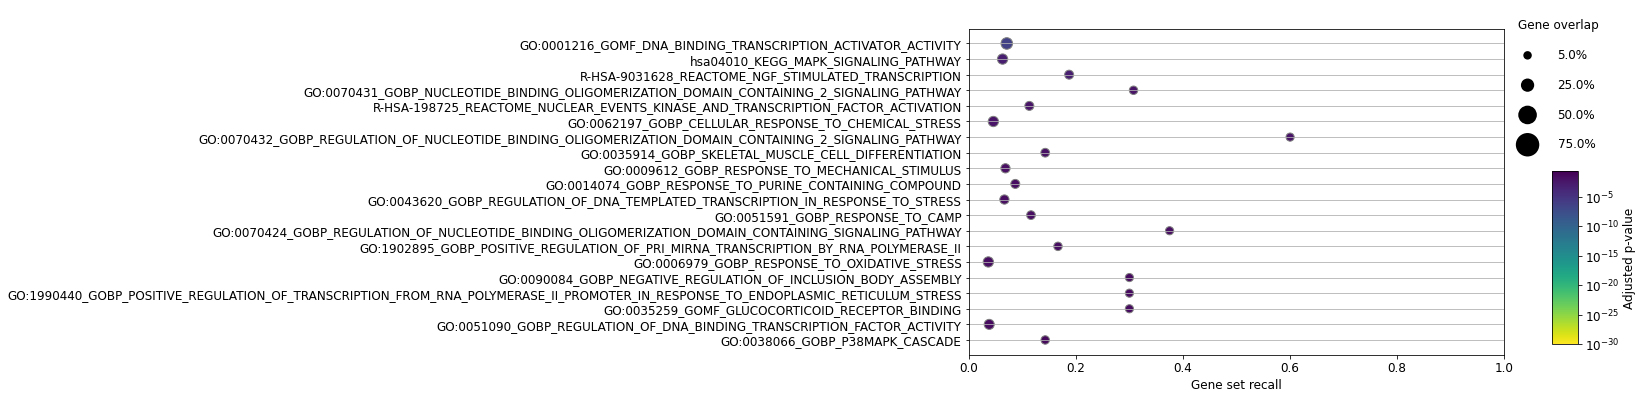

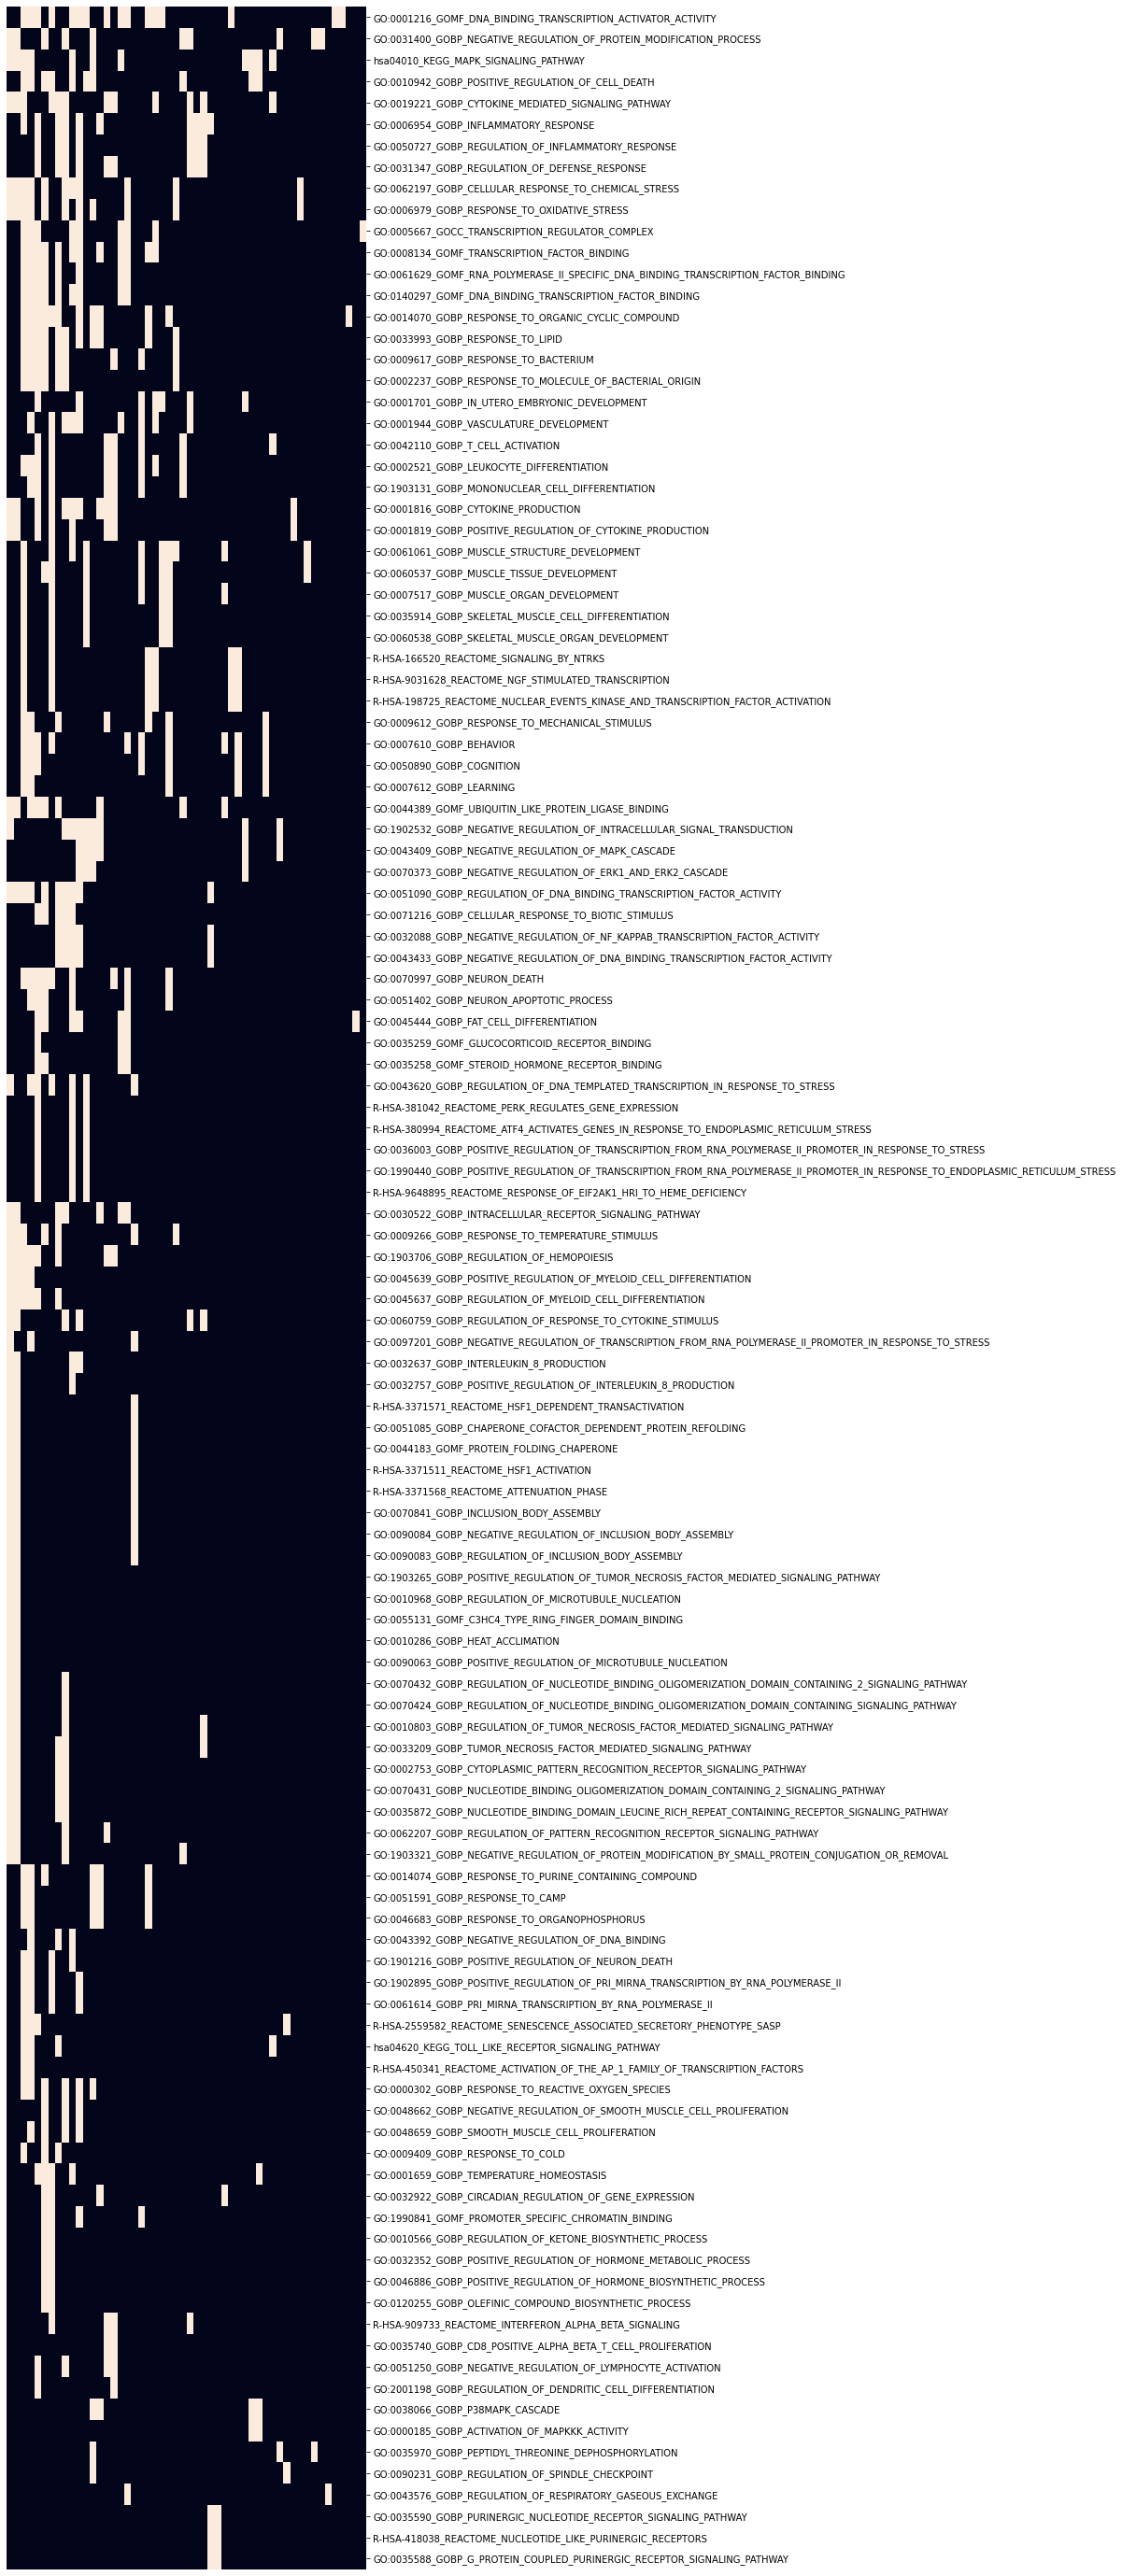

CL down_3 N genes 216
N enriched gene sets: 89
Top enriched gene sets


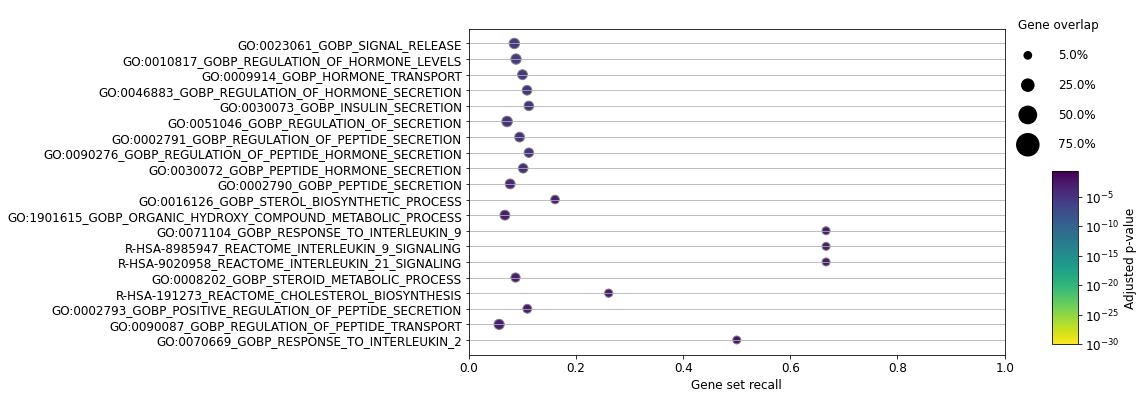

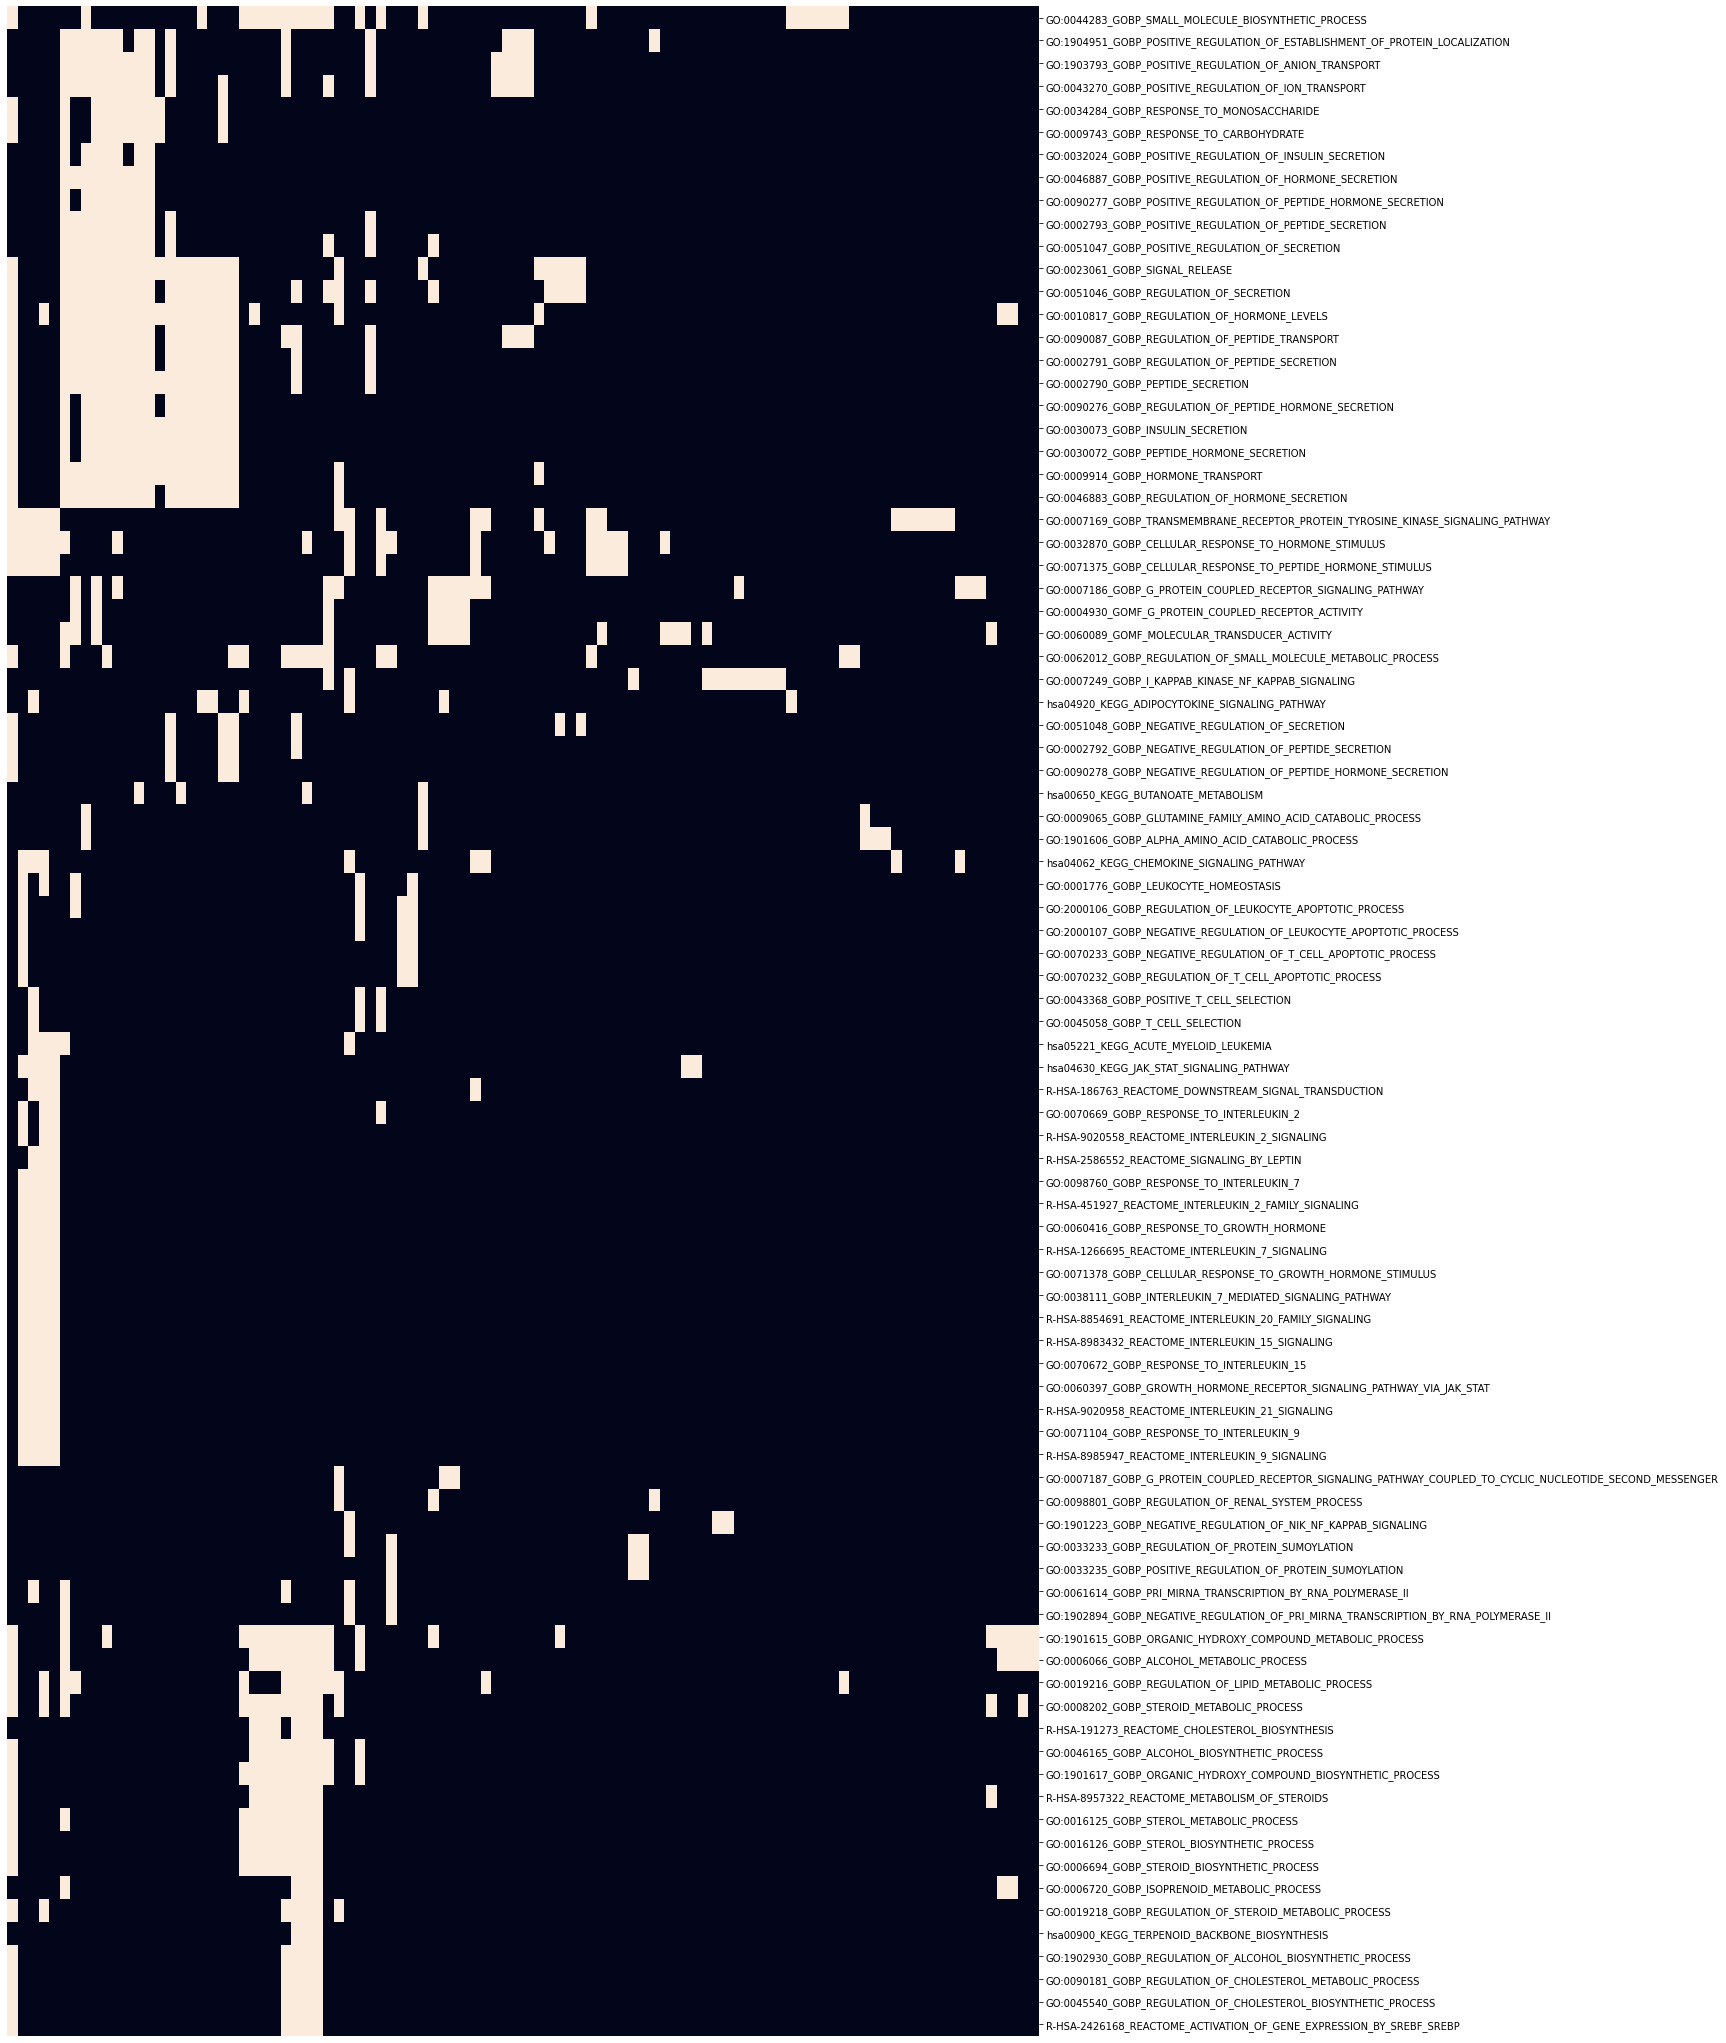

CL down_4 N genes 200
N enriched gene sets: 11
Top enriched gene sets


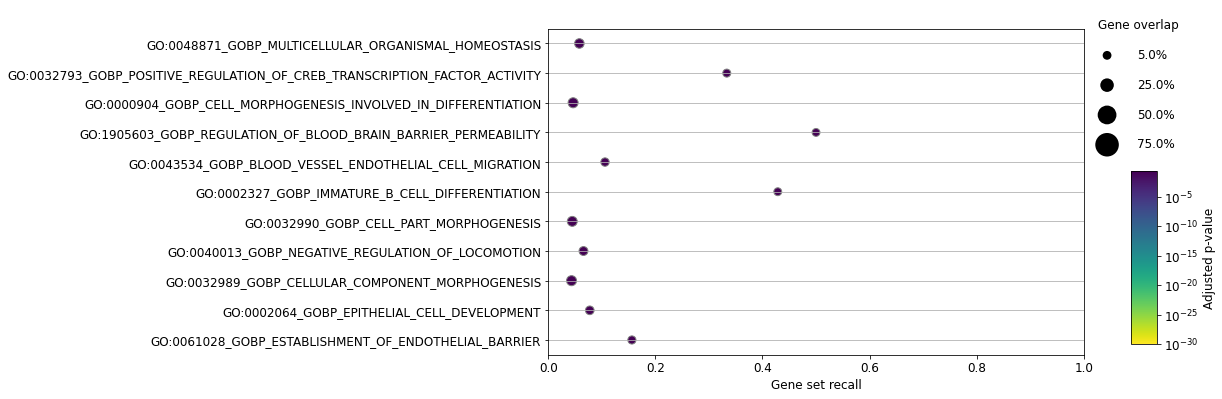

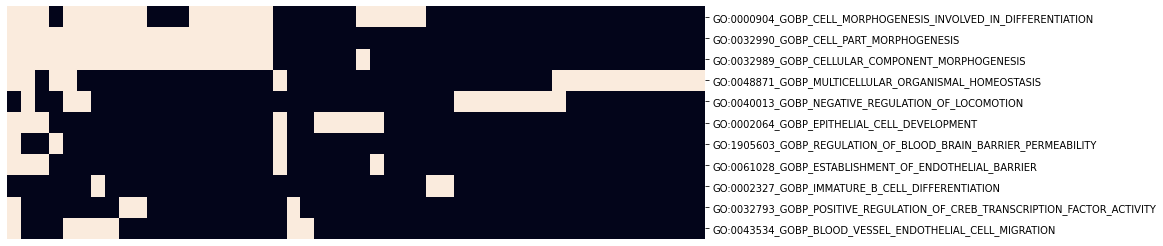

CL down_5 N genes 52
N enriched gene sets: 42
Top enriched gene sets


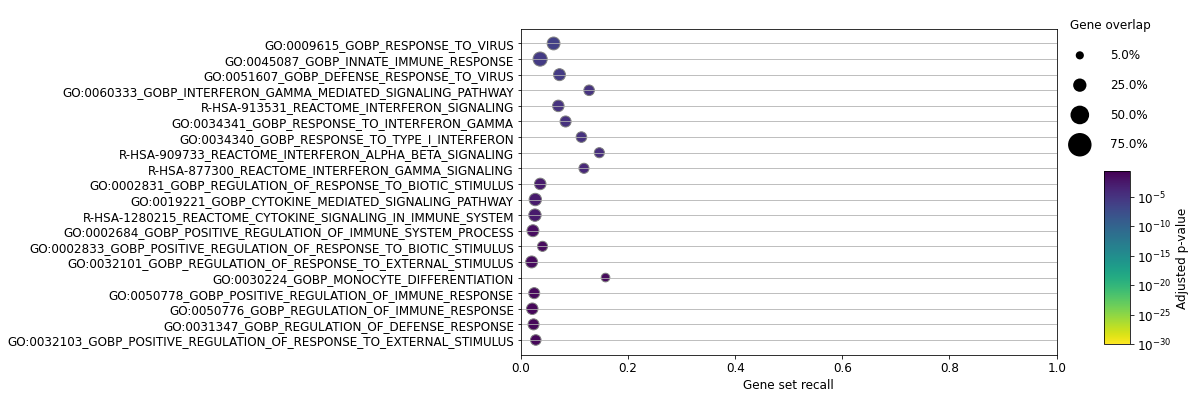

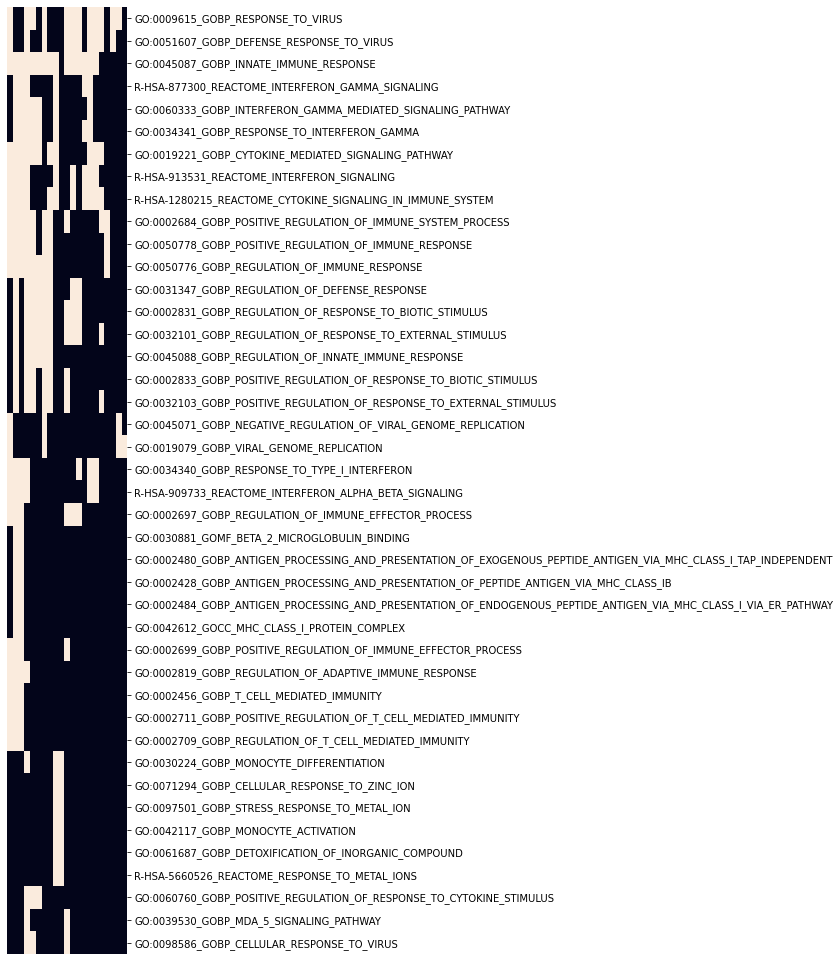

CL down_6 N genes 144
N enriched gene sets: 0
CL down_7 N genes 110
N enriched gene sets: 0
CL up_1 N genes 53
N enriched gene sets: 19
Top enriched gene sets


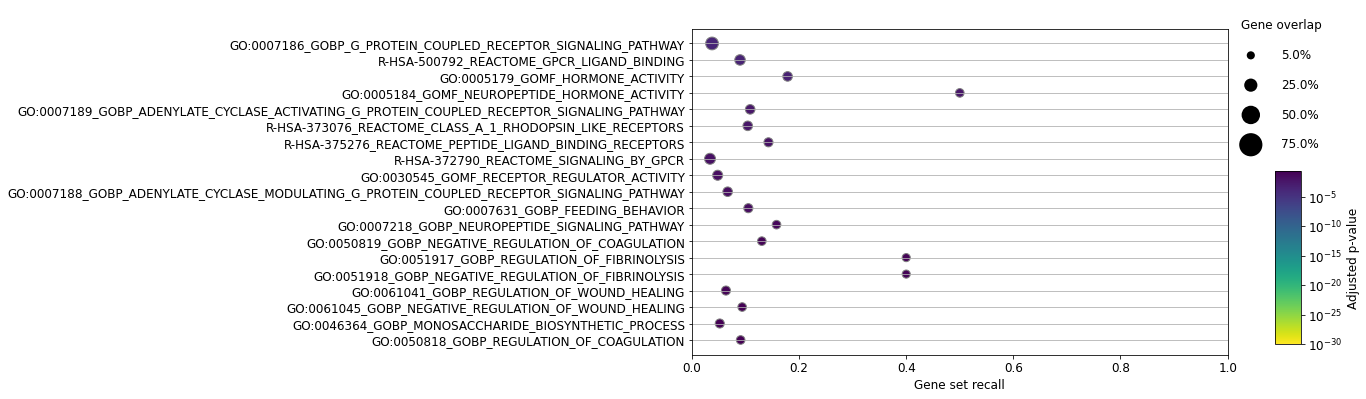

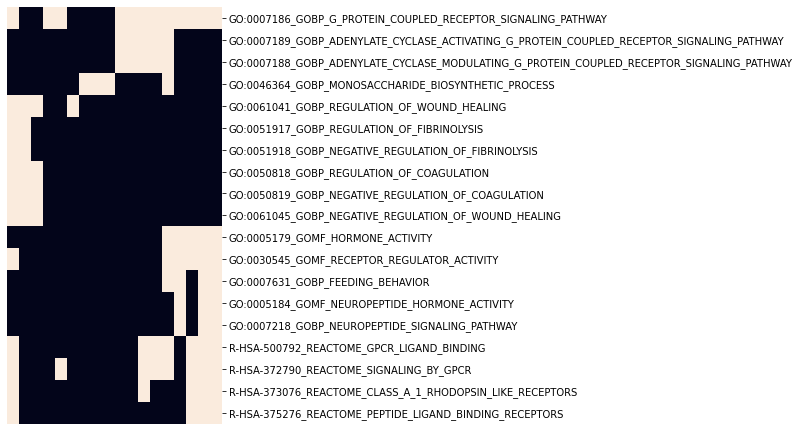

CL up_2 N genes 349
N enriched gene sets: 75
Top enriched gene sets


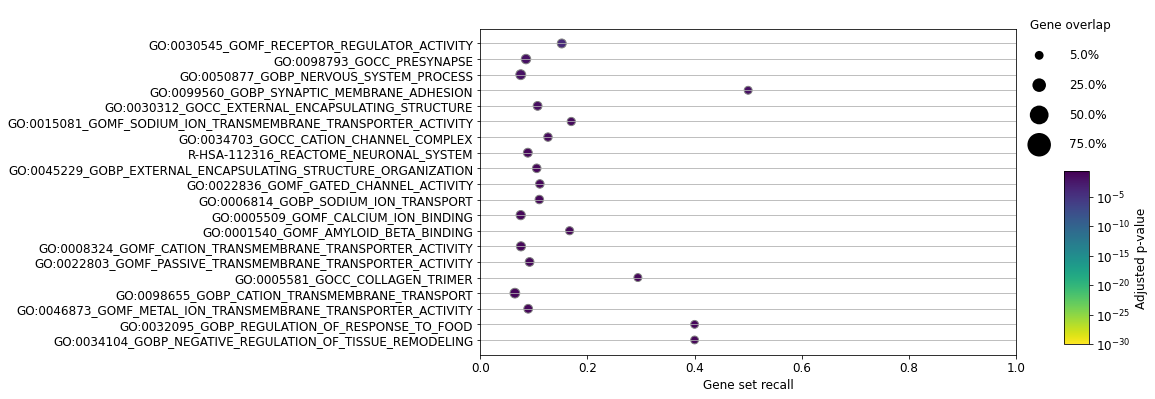

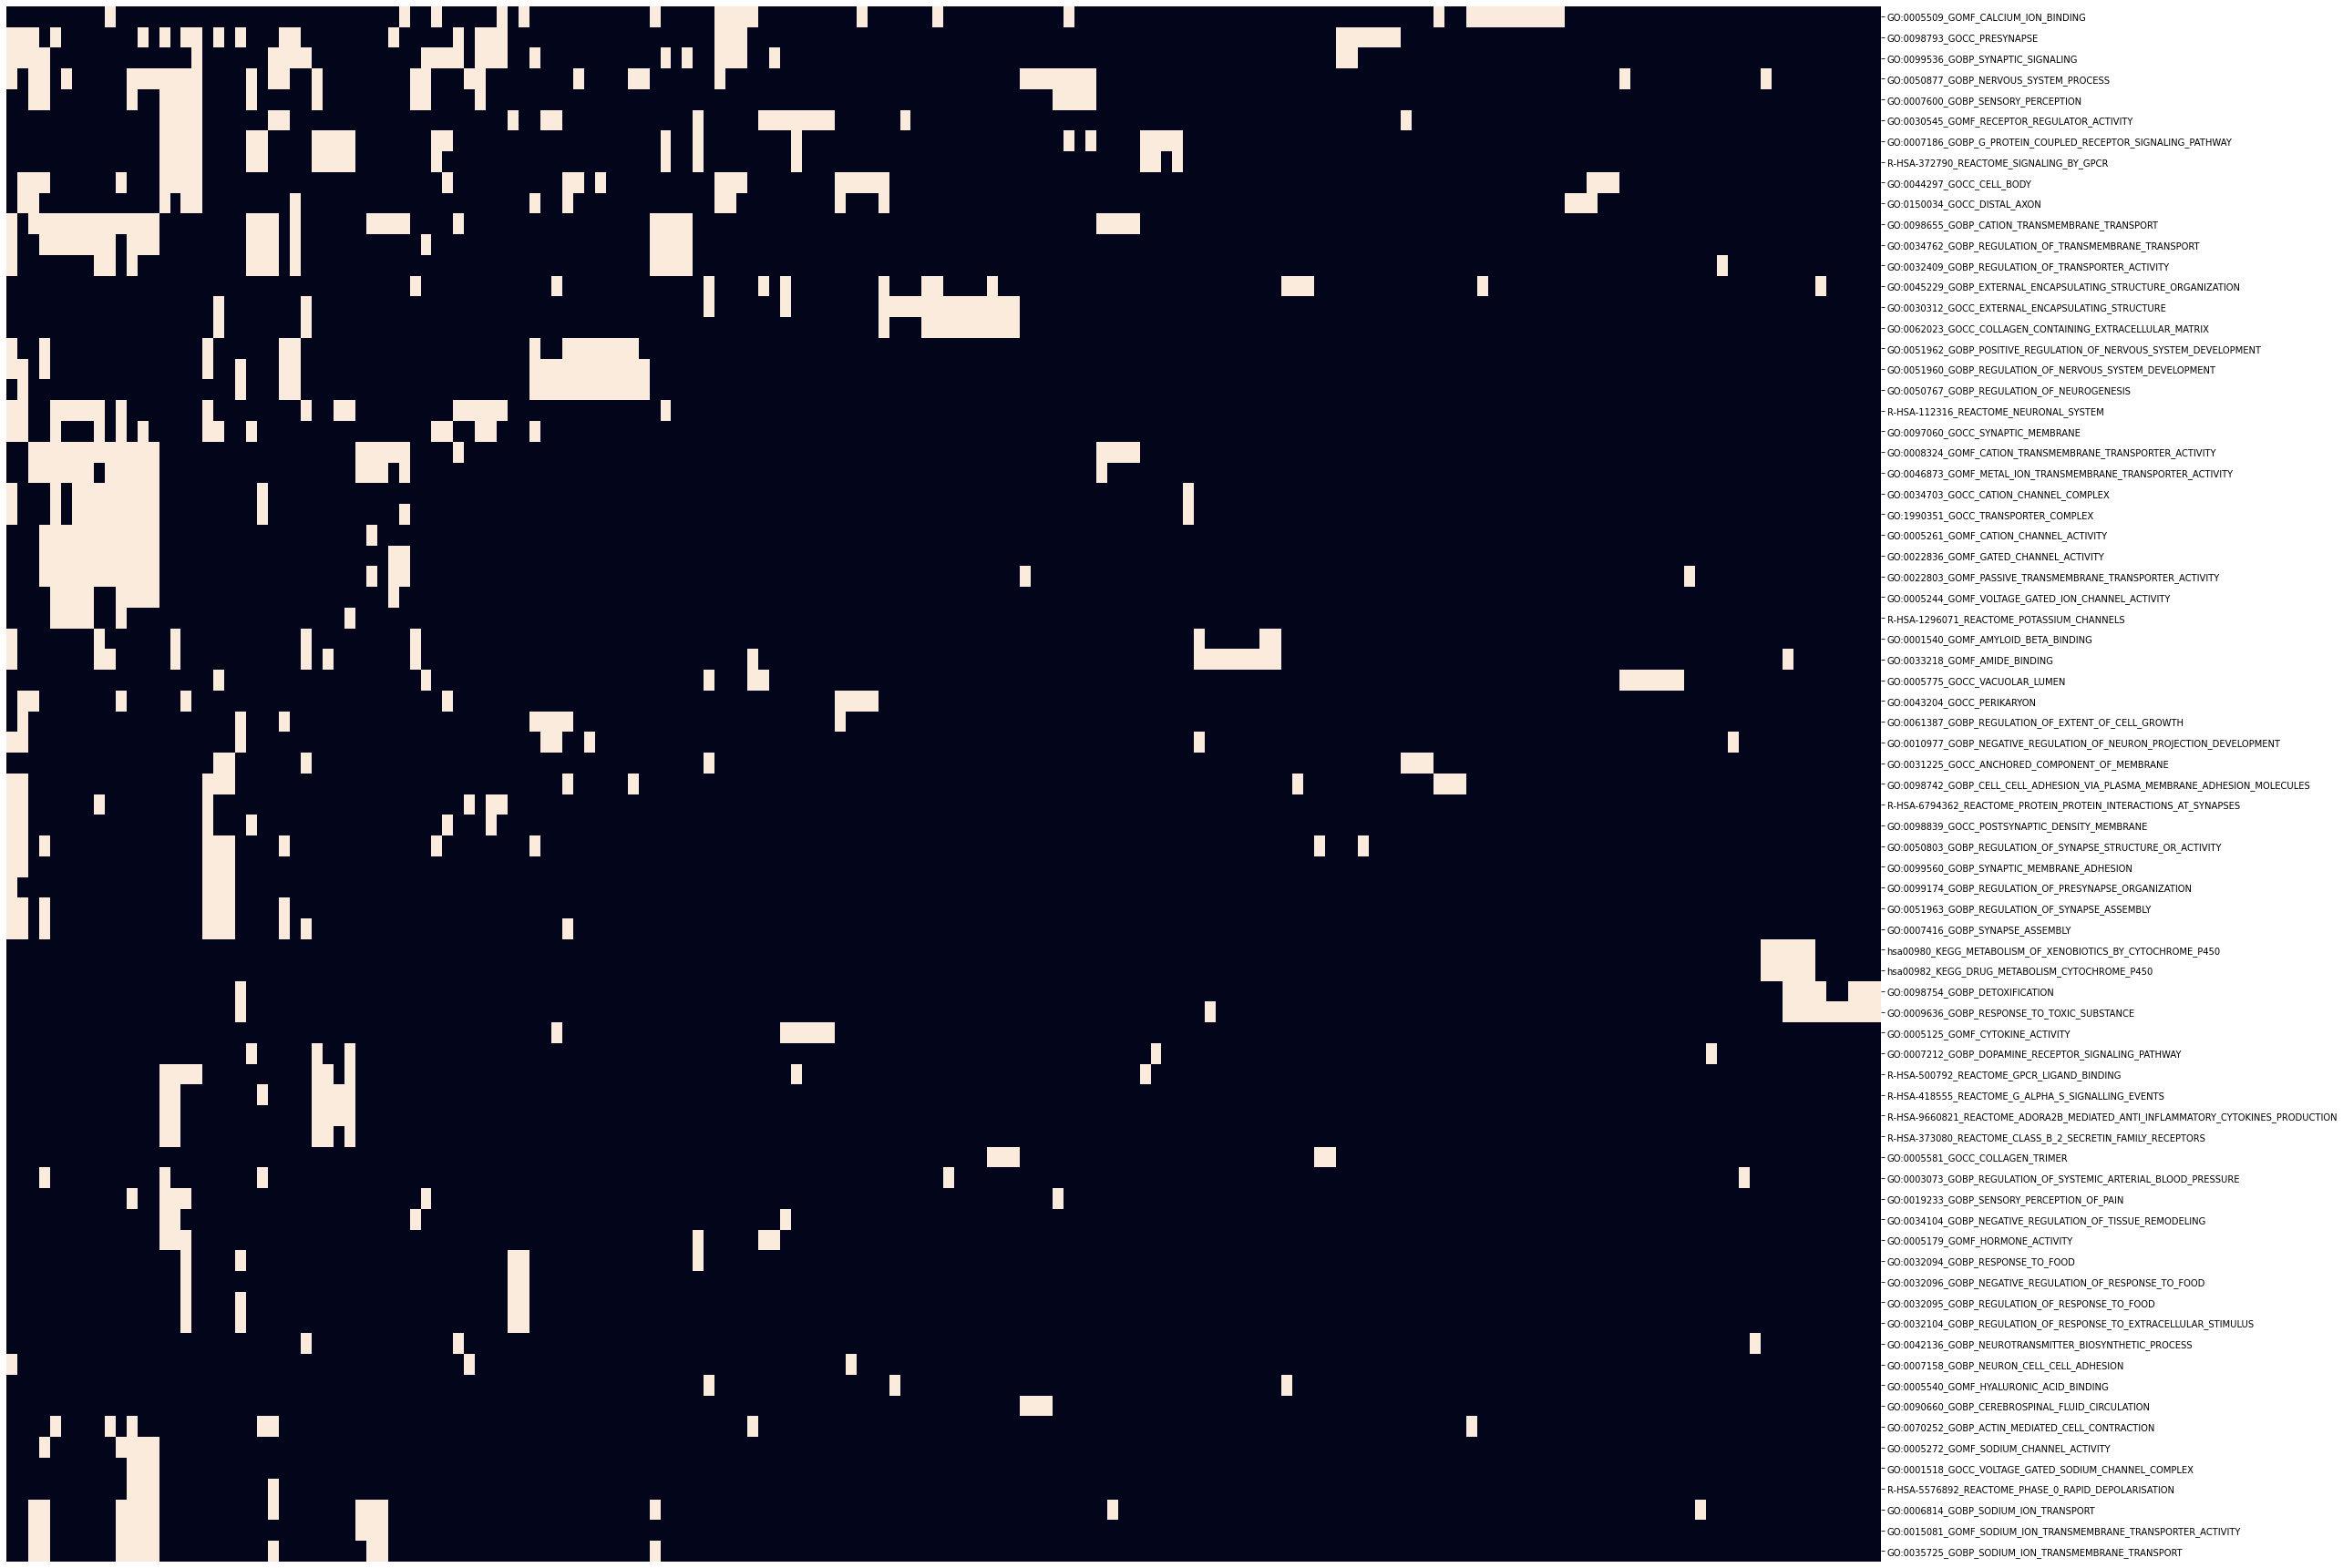

CL up_3 N genes 22
N enriched gene sets: 0


In [237]:
enrich_fdr=0.25
ro.globalenv['gs_fdr']=enrich_fdr
enrich_datas={}
for cl in sorted(adata_genes.obs['hc'].unique()):
    genes=adata_genes.obs.query('hc==@cl').index
    print('CL %s N genes %i'%(cl,len(genes)))
    # Map to gene symbols
    genes=summary.loc[genes,'gene_symbol'].dropna().tolist()

    # Calculate enrichment
    ro.globalenv['genes']=genes
    res=ro.r(f'hypeR(signature=as.vector(unlist(genes)),genesets=gene_sets,test = "hypergeometric",background =  as.vector(unlist(ref)),pval = 1,fdr = gs_fdr,plotting = FALSE,quiet = TRUE)')
    ro.globalenv['res']=res
    data=ro.r(f'res$data')
    enrich_datas[cl]=data
    print('N enriched gene sets:',data.shape[0])
    
    if data.shape[0]>0:
        # Plot top enriched gene sets
        print('Top enriched gene sets')
        data['recall']=data['overlap']/data['geneset']
        data['query_size']=len(genes)
        h.plot_enrich(data=data.rename(
            {'label':'name','fdr':'p_value','overlap':'intersection_size'},axis=1),
            n_terms=20, save=False,min_pval=10**-30, max_pval=enrich_fdr,percent_size=True,
               recall_lim=(0,1))
        h.plot_enr_heatmap(data=data,n_gs=None,xticklabels=False,yticklabels=True)
# Save enrichment tables
writer = pd.ExcelWriter(path_de+'deDataClusters_enrichment.xlsx',
                        engine='xlsxwriter') 
for sheet,data in enrich_datas.items():
    data.to_excel(writer, sheet_name=str(sheet))   
writer.save()

## Save clusters
Gene id, name, cluster, other gene statistics

In [173]:
# Add data to De summary
summary_data=summary.copy()
summary_data['hc']=adata_genes.obs.copy().reindex(summary_data.index.values)['hc']
summary_data['rel_beta_expr']=genes_info.loc[summary_data.index,'rel_maxscl_beta_expr_cl'].values
summary_data[['mean_expr_in_expr_cells','N_PMID','N_PMID_pancreas_notCancerNonendo']]=\
    genes_info.loc[summary_data.index,
                   ['mean_expr_in_expr_cells','N_PMID','N_PMID_pancreas_notCancerNonendo']]

In [13]:
summary_data

gene      pval      qval    log2fc        mean  \
0      ENSMUSG00000051951  0.000011  0.000013  0.307300    0.066066   
1      ENSMUSG00000033845  0.000000  0.000000  0.184043    0.861142   
2      ENSMUSG00000025903  0.000000  0.000000 -0.455122    0.507621   
3      ENSMUSG00000033813  0.000000  0.000000 -0.326792    1.148189   
4      ENSMUSG00000033793  0.000000  0.000000 -0.338769    0.883926   
...                   ...       ...       ...       ...         ...   
11144  ENSMUSG00000064368  0.603101  0.614679  0.014795    0.528503   
11145  ENSMUSG00000064370  0.000000  0.000000 -0.434244  131.996829   
11146  ENSMUSG00000051412  0.000000  0.000000  0.239062    1.277671   
11147  ENSMUSG00000095041  0.000000  0.000000 -0.359222    1.117523   
11148  ENSMUSG00000063897  0.000000  0.000000  0.463859    0.902928   

       zero_mean          grad  coef_mle   coef_sd             ll  \
0          False  4.337062e-08  0.307300  0.069771  -10674.083488   
1          False  1.112048e-06  0.184043  0.020849  -54567.283849   
2          False  1.739494e-06 -0.455122  0.024659  -42143.793666   
3          False  9.631941e-07 -0.326792  0.017958  -62806.836425   
4          False  1.142498e-06 -0.338769  0.019809  -56385.526102   
...          ...           ...       ...       ...            ...   
11144      False  6.308996e-07  0.014795  0.028455  -39320.472155   
11145      False  2.304797e-07 -0.434244  0.007934 -242922.730736   
11146      False  6.119591e-07  0.239062  0.018181  -64690.746931   
11147      False  8.585163e-07 -0.359222  0.018486  -62967.233150   
11148      False  3.424977e-07  0.463859  0.021482  -55690.567151   

          gene_symbol   hc  rel_beta_expr  N_PMID  \
0                Xkr4  NaN       1.000000    11.0   
1              Mrpl15  NaN       0.577643    55.0   
2              Lypla1  NaN       0.755665    42.0   
3               Tcea1  NaN       0.898695    66.0   
4             Atp6v1h  NaN       1.000000    65.0   
...               ...  ...            ...     ...   
11144          mt-Nd6  NaN       1.000000    42.0   
11145         mt-Cytb  NaN       1.000000    39.0   
11146           Vamp7  NaN       1.000000     0.0   
11147      AC149090.1  NaN       1.000000     0.0   
11148  CAAA01118383.1  NaN       0.619154     0.0   

       N_PMID_pancreas_notCancerNonendo  mean_expr_in_expr_cells  
0                                   0.0                 0.487778  
1                                   0.0                 0.665728  
2                                   0.0                 0.617923  
3                                   0.0                 0.794732  
4                                   1.0                 0.706451  
...                                 ...                      ...  
11144                               4.0                 0.684435  
11145                               5.0                 4.252210  
11146                               0.0                 0.746626  
11147                               0.0                 0.812761  
11148                               0.0                 0.673011  

[11149 rows x 16 columns]

In [9]:
# Save
summary_data.to_csv(path_de+'deDataClusters.tsv',index=False,sep='\t')

## Expression in embryo

In [9]:
# Add gene EIDs to index for making plots
summary_data.index=summary_data.gene

Embryonic cell types

In [10]:
adata_rn.obs.query('study=="embryo"').pre_cell_type.\
    cat.remove_unused_categories().value_counts()

Mat. Acinar     6972
Ductal          4262
Tip             3796
Prlf. Acinar    3289
Ngn3 low EP     2582
Ngn3 high EP    2493
Prlf. Ductal    2298
Prlf. Tip       2193
Fev+            2058
NA              1641
Alpha           1422
Beta            1232
Prlf. Trunk     1188
Multipotent     1187
Trunk            615
Epsilon          230
Delta            103
Name: pre_cell_type, dtype: int64

C: Cl NA must be ommited as its cells are not annotated in paper but used in my data

Prepare expression data

In [14]:
# Create data with mean expression over beta clusters and embryonic cell clusters for T2D genes
# Add colors for different cell cl groups
genes_up=summary_data.query('qval<@FDR & log2fc>@ALFC & rel_beta_expr>0.2').gene
data_m_cl=pd.DataFrame(columns=genes_up)
cl_colors=pd.Series()
cell_cl_names=pd.Series()
cl_color_map={'embryo':'#17becf','beta non-diabetic':'#59bd4a',
             'beta db/db+mSTZ':'#d94d43','beta NOD':'#f084cf','beta D-inter.':'#bcbd22'}
# Embryo cl averages
for cl in adata_rn.obs.query('study=="embryo"').pre_cell_type.\
    cat.remove_unused_categories().value_counts().index:
    if cl!="NA":
        cells=adata_rn.obs.query('study=="embryo" &pre_cell_type==@cl').index
        name=cl.replace(' ','')
        data_m_cl.loc[name,genes_up]=\
            np.array(adata_rn[cells,genes_up].X.mean(axis=0)).ravel()
        cl_colors[name]=cl_color_map['embryo']
        cell_cl_names[name]='embryo'
# Beta clusters cl averages 
for cl in beta_obs.hc_gene_programs.cat.categories:
    cl_parsed=beta_obs.query('hc_gene_programs==@cl')['hc_gene_programs_parsed'][0]
    cells=beta_obs.query('hc_gene_programs==@cl').index
    name=str(cl_parsed)
    data_m_cl.loc[name,genes_up]=\
        np.array(adata_rn[cells,genes_up].X.mean(axis=0)).ravel()
    if cl in [1,2,3,4]:
        cl_colors[name]=cl_color_map['beta db/db+mSTZ']
        cell_cl_names[name]='beta db/db+mSTZ'
    elif cl in [21]:
        cl_colors[name]=cl_color_map['beta NOD']
        cell_cl_names[name]='beta NOD'
    elif cl in [20]:
        cl_colors[name]=cl_color_map['beta D-inter.']
        cell_cl_names[name]='beta D-inter.'
    else:
        cl_colors[name]=cl_color_map['beta non-diabetic']
        cell_cl_names[name]='beta non-diabetic'
# Scale by max value
data_m_cl=pd.DataFrame(maxabs_scale(data_m_cl),
                       index=data_m_cl.index,columns=data_m_cl.columns)
data_m_cl.columns.name='Genes'
data_m_cl.index.name='Cell clusters'

# Opt order genes
gene_list= h.opt_order_withincl(data_m_cl.T, 
                                pd.Series(['0']*data_m_cl.shape[1],index=data_m_cl.columns))
# Opt order cells
cell_list= h.opt_order_withincl(data_m_cl, 
                                pd.Series(['0']*data_m_cl.shape[0],index=data_m_cl.index))

<ipython-input-14-75f20a2ad677>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cl_colors=pd.Series()
<ipython-input-14-75f20a2ad677>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cell_cl_names=pd.Series()


R heatmap

In [16]:
# Cell colors names
cell_list_names=cell_cl_names.loc[cell_list].values
cl_color_map_k=list(cl_color_map.keys())
cl_color_map_v=list(cl_color_map.values())

In [17]:
%%R -i cell_list_names -i cl_color_map_k -i cl_color_map_v
# Cell cl splitting and annotation
col<-list(setNames( unlist(cl_color_map_v),unlist(cl_color_map_k)))
names(col)<-c("cell group")
ha_col=rowAnnotation(
    'cell group' = unlist(cell_list_names),
    col = col,
    show_annotation_name = c(cell_group = FALSE),
    show_legend=TRUE
)

In [18]:
# genes for anno
genes=['Tcf7l1','Cd24a','Fabp5','Gc', 'Mbl2','Nucb2','Apoa2','Cck','Pam',
 'Chgb','Gng2','Bambi','Slc38a5','Gast',  'Prss1', 'Plaur','Slc5a10', 'Cartpt',
 'Sftpd','Ptger3','Cd59a','Slc22a4','Fgf1','Dgkb']
genes_show=[]
genes_show_eid=[]
for g in genes:
    eids=summary_data.query('gene_symbol==@g').gene.values
    if len(eids)!=1:
        raise ValueError("Found not exactly 1 eid for gene:",g,eids)
    else:
        for eid in eids:
            if eid in gene_list:
                genes_show_eid.append(eid)
                genes_show.append(g)
            else:
                print(eid, summary_data.at[eid,'gene_symbol'], 'not in data')
genes_show_idx=[np.argwhere(np.array(gene_list)==g)[0][0] for g in genes_show_eid]

ENSMUSG00000031170 Slc38a5 not in data
ENSMUSG00000062751 Prss1 not in data
ENSMUSG00000046223 Plaur not in data
ENSMUSG00000021795 Sftpd not in data


In [19]:
%%R -i genes_show -i genes_show_idx
# Gene info annotation - names and marking subtype
ha_row = columnAnnotation(
    genes=anno_mark(at = unlist(genes_show_idx), labels = unlist(genes_show)),
    annotation_name_side = "left"
)

In [20]:
# Order and rename data
x=data_m_cl.loc[cell_list,gene_list]

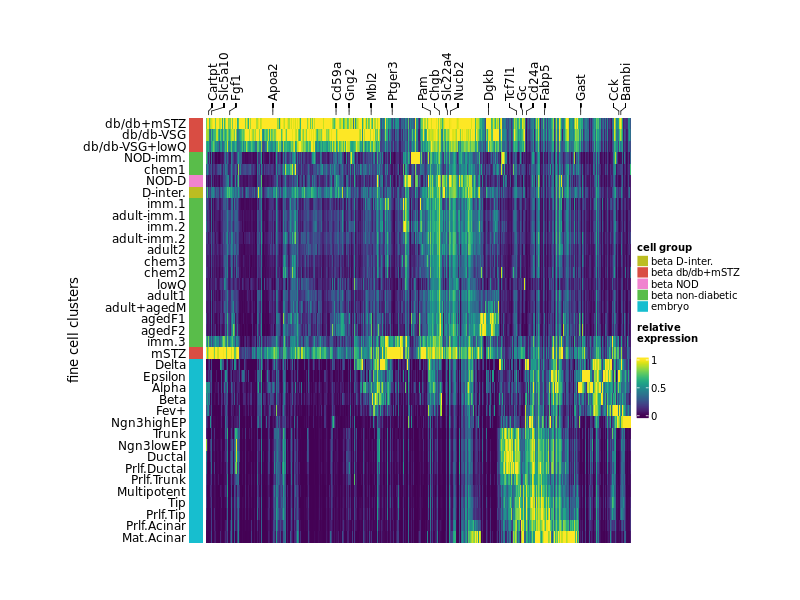

In [21]:
%%R -w 800 -h 600 -i x 
h<-Heatmap(x,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = FALSE, show_row_names = TRUE,
       row_title ="fine cell clusters",
       top_annotation=ha_row,
       left_annotation=ha_col,row_names_side = "left",
       heatmap_legend_param = list( title = "relative \nexpression\n"),
       row_gap = unit(0, "mm"),
       width= unit(15, "cm"), height= unit(15, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

Save plot

In [22]:
%%R -i x -i path_fig
# For some reason it does not get saved as png
png(file=paste0(path_fig,"heatmap_beta_VSGSTZEmbryo.png"), width=5000, height=5000,res=500)
h<-Heatmap(x,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = FALSE, show_row_names = TRUE,
       row_title ="fine cell clusters",
       top_annotation=ha_row,
       left_annotation=ha_col,row_names_side = "left",
       heatmap_legend_param = list( title = "relative \nexpression\n"),
       row_gap = unit(0, "mm"),
       width= unit(15, "cm"), height= unit(15, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)
dev.off()

[1] 2


In [23]:
%R paste0(path_fig,"heatmap_beta_VSGSTZEmbryo.png")

array(['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/heatmap_beta_VSGSTZEmbryo.png'],
      dtype='<U102')